In [1]:
import sys
import sqlite3 as sql
import importlib

from math import *;
from os.path import basename;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

import numpy as np
import geom
import matplotlib.image as image
import matplotlib.pyplot as plt
import importlib
import sonalleve 
import transducers

import MRDataAnalysis
#from matplotlib.mlab import griddata

import matplotlib.transforms as mpl_trans

import scipy.interpolate as snt
import scipy.ndimage.filters as sflt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import nibabel
import visvis as vv
#os.chdir('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\path_optimization\\')

%matplotlib inline
np.set_printoptions(precision=4, suppress=True, threshold=1300)

plt.rc('font', family='sans-serif', size=20)

C:\Users\Vandiver\Anaconda3\lib\site-packages\visvis\processing\calculateNormals.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  faces = np.arange(N); faces.shape = len(v)/3,3


In [ ]:
importlib.reload(MRDataAnalysis)

In [ ]:
importlib.reload(transducers)

In [3]:
file1="/Users/Vandiver/Data/sonalleve/HifuEggAg_20160211/scan10_TemperatureMappingCLEAR10_20160211.PAR"
#file2="/Users/Vandiver/Data/sonalleve/HifuEggAg_20160211/scan7_TemperatureMapping_20160217.PAR"
file1="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan25_TempCor_20160413.PAR" 
file1="/Users/Vandiver/Data/sonalleve/HifuVol_20160223B/scan4"

(tempdata1,complIm1,im1, dyntimes1)= MRDataAnalysis.read_TempScan(file1,MP_interleaved=True, phase_unwrap=1, pi_val=-0.2)
#(tempdata2,complIm2,im2, dyntimes2)= MRDataAnalysis.read_TempScan(file2,MP_interleaved=True, phase_unwrap=1, pi_val=-0.2)

aff1=im1.get_affine()
invaff1=np.linalg.inv(aff1)

RASsliceAxis=np.where( np.abs( np.abs( aff1.dot([0,0,1,1]  ) - aff1.dot([0,0,0,1]  ) )) > 0 )[0][0]

hifuAxisDimension = np.where( np.abs( np.abs( invaff1.dot([0,0,0,1]  ) - invaff1.dot([0,1,0,1]  ) )) > 0 )[0][0]

print("RASsliceAxis = ",RASsliceAxis)
print("hifuAxisDimension = ",hifuAxisDimension)

print(tempdata1.shape)
(junk,junk,nslc1,ndyn1)=tempdata1.shape

RASsliceAxis =  1
hifuAxisDimension =  1
(160, 160, 15, 30)


In [ ]:
simToDataR = MRDataAnalysis.LPH_to_RAS().dot( MRDataAnalysis.Tpom_from_Orientation('Head First Supine') )

uRAS,focus=sonalleve.get_sonalleve_xdc_vecs(R=simToDataR, ret_focus=True)
unormalsRAS = sonalleve.get_sonalleve_xdc_normals(R=simToDataR)
uRAS-=focus
focus-=focus
uRASmm=1000.0*uRAS

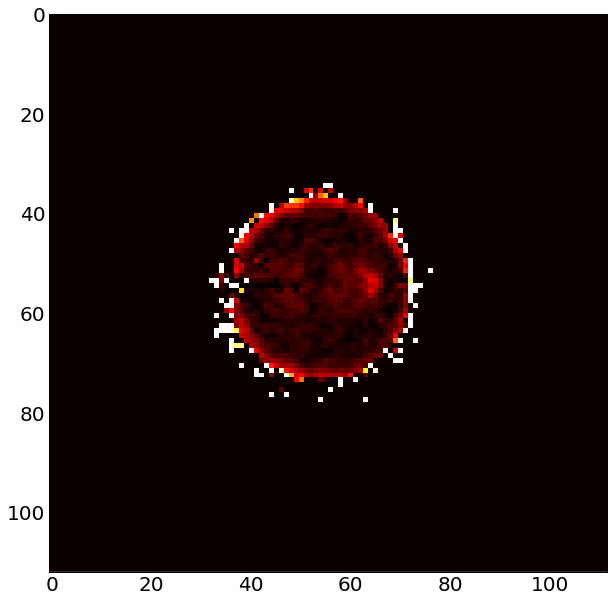

In [20]:
plt.figure(figsize=(10,10))
plt.imshow( (tempdata1[:,:,2,30]), vmin=0,vmax=30, cmap=image.cm.hot,interpolation='None' )

In [7]:
im1.header.get_zooms()

(1.776, 1.7759999999999998, 4.0, 0.024272)

In [ ]:
db = "/Users/Vandiver/Data/sonalleve/sonalleve.db"
con = sql.connect(db)
con.row_factory = sql.Row

In [ ]:
cur=con.execute("select * from data where file = ?", [basename(file1)] )

In [ ]:
rw=cur.fetchone()

In [ ]:
v0a,v0b,v1a,v1b,v2a,v2b=rw['start0'],rw['end0'],rw['start1'],rw['end1'],rw['start2'],rw['end2']
targetCenterVox_f=[(v0a+v0b)/2.0, (v1a+v1b)/2.0, (v2a+v2b)/2.0  ]
targetCenterRASmm=aff1[0:3,0:3].dot(targetCenterVox_f) +aff1[0:3,3]

u_RAS_offset = uRAS + targetCenterRASmm/1000.0

In [ ]:
#simpntsR = np.linspace(-20,20,80) 
simpntsR = targetCenterRASmm[0:1]
simpntsA = np.linspace(-40,40,80) #HIFU axis negative direction
#simpntsS = np.linspace(-20,20,80) 
simpntsS = targetCenterRASmm[2:3]

In [ ]:
NN = uRAS.shape[0]
rho=1020.0
c0=1540.0
k0 = 2*pi*1.2e6/(c0)
Prsim = transducers.calc_pressure_field_cuda(k0, u_RAS_offset, unormalsRAS, np.ones(NN)/NN,
                                             simpntsR*1e-3,simpntsA*1e-3,simpntsS*1e-3, 
                                             subsampN=60, subsampDiam=0.0033, ROC=0.14 )

In [ ]:

Pr1d = transducers.calc_pressure_profile_cuda(k0, u_RAS_offset, unormalsRAS, np.ones(NN)/NN,
                                             np.ones_like(simpntsA)*targetCenterRASmm[0]*1e-3,
                                              simpntsA*1e-3,
                                              np.ones_like(simpntsA)*targetCenterRASmm[2]*1e-3, 
                                             subsampN=60, subsampDiam=0.0033, ROC=0.14)

In [ ]:
resamp=np.linspace(-40,40,50)
m00=imagemanip.calc_bin2bin_Filter(simpntsA, resamp,preserve_norm=True)
Presamp=m00.dot(Pr1d[0:-1])

In [ ]:
resamp.shape

In [ ]:
plt.plot(simpntsA, np.abs(Pr1d),'-o' )
plt.plot(resamp[0:-1]+0.5*(resamp[1]-resamp[0]), np.abs(Presamp),'-o' )

In [ ]:
fitVoxEdges0 = np.arange(v0a,v0b+2)
fitVoxEdges1 = np.arange(v1a,v1b+2)
fitVoxEdges2 = np.arange(v2a,v2b+2)

fitVox0=fitVoxEdges0[0:-1]
fitVox1=fitVoxEdges1[0:-1]
fitVox2=fitVoxEdges2[0:-1]

margin=[5,10,2]
voxstep=[0.1,0.25,0.25]
simVoxEdges0 = np.arange(v0a - margin[0], v0b+1.000+ margin[0], voxstep[0] )
simVoxEdges1 = np.arange(v1a - margin[1], v1b+1.000+ margin[1], voxstep[1])
simVoxEdges2 = np.arange(v2a - margin[2], v2b+1.000+ margin[2], voxstep[2])

simVox0=simVoxEdges0[0:-1]
simVox1=simVoxEdges1[0:-1]
simVox2=simVoxEdges2[0:-1]

simMesh0, simMesh1, simMesh2 = np.meshgrid(simVox0, simVox1, simVox2,indexing='ij')

#image coordinates are rectilinear and the affine does not apply any deformation. thus applying the affine is the
#same as a rotation and the 
simMeshR, simMeshA, simMeshS = geom.rotate_mesh_volume(aff1[0:3,0:3], simMesh0, simMesh1, simMesh2, translate=aff1[0:3,3])



In [ ]:
simMeshR.shape

In [ ]:
np.tensordot()

In [ ]:
Psim3d = transducers.calc_pressure_mesh3D_cuda(k0, u_RAS_offset, unormalsRAS, np.ones(NN)/NN,
                                             simMeshR*1e-3,simMeshA*1e-3,simMeshS*1e-3, 
                                             subsampN=10, subsampDiam=0.0033, ROC=0.14 )

In [ ]:
plt.imshow(np.abs(Psim3d[:,:,15])**2, interpolation='none')

In [ ]:
aff1[0:3,0:3].dot(centerVox_f) +aff1[0:3,3]

In [ ]:
tempdata1[v0a:v0b+1, v1a:v1b+1, v2a:v2b+1, 5].shape

In [ ]:
tuple(map(lambda x: [x], range(4-1,-1,-1) ) )

In [ ]:
importlib.reload(imagemanip)

In [ ]:
import imagemanip

In [ ]:
fitVox0=np.arange(65.0,71.0,1.0)
simVox0=np.arange(65.0,73.0,0.5)

In [ ]:
f00=imagemanip.calc_bin2bin_Filter(fitVoxEdges0, simVoxEdges0)

In [ ]:
if00=imagemanip.calc_bin2bin_Filter(simVoxEdges0, fitVoxEdges0)

In [ ]:
if00.shape

In [ ]:
fitVox0

In [ ]:
simVox0

In [ ]:
if00.dot(f00)

In [ ]:
if00.dot(tt) - tempdata1[v0a:v0b+1,v1a,v2a,5] 

In [ ]:
tt=f00.dot( tempdata1[v0a:v0b+1,v1a,v2a,5] )

In [ ]:
np.sum(tempdata1[v0a:v0b+1,v1a,v2a,5]) - np.sum(tt)

In [ ]:
fitVox0.shape

In [ ]:
plt.plot( simVox0, tt,'.-' )
plt.plot( fitVox0, if00.dot(tt),'.-' )

In [ ]:
plt.plot( fitVox0, tempdata1[v0a:v0b+1,v1a,v2a,5] )
plt.plot( simVox0, tt )

In [ ]:
fitVox0

In [ ]:
def trapezoidal(x,xvalues, fvalues,xa=None, dx=None):
    if dx is None:
        dx = xvalues[1:]-xvalues[0:-1]
    if xa is None or xa <= xvalues[0]:
        xa=xvalues[0]
        bina=0
        
        if x < xa:
            return 0.0
    elif x < xa:
        return 0.0
    else:
        bina = np.where(np.logical_and(xa>=xvalues[0:-1], xa<xvalues[1:]) )[0][0]
        
    integral=0.0    
    
    if x >= xvalues[-1]:
        binb = len(xvalues)-1
    else:   
        binb = np.where(np.logical_and(x>=xvalues[0:-1], x<xvalues[1:]) )[0][0]
        
        xs = (x - xvalues[binb])
        xss= xs*(x + xvalues[binb])
        
        integral += xss*(fvalues[binb+1] - fvalues[binb]) / dx[binb]  + fvalues[binb]*xs
    
    
    xs = (xvalues[bina+1] - xa)
    xss= (xvalues[bina+1] + xa)*xs

    integral += xss*(fvalues[bina+1] - fvalues[bina]) / dx[bina]  + fvalues[bina]*xs
    
    for b in range(bina+1,binb,1):
        integral += (fvalues[b]+fvalues[b+1]) * dx[b]/2 .0
    
    
    
    return integral
    

In [248]:
X=np.arange(50.0, 90.0, 1.)
#X=np.arange(65, 76, 1.)
xa=X
xb=X.copy()
xb[0:-1]=xa[1:]-xa[0:-1]
xb[-1]=xb[-2]

In [249]:
FX = 0.001*(X-65)**3 - 0.03*(X-65)**2 + 10
X

array([ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.])

In [250]:
step=0.3
Y = np.arange(50.0, 90.0, step)+0.0
dY = np.ones_like(Y)*step

In [251]:
Y

array([ 50. ,  50.3,  50.6,  50.9,  51.2,  51.5,  51.8,  52.1,  52.4,
        52.7,  53. ,  53.3,  53.6,  53.9,  54.2,  54.5,  54.8,  55.1,
        55.4,  55.7,  56. ,  56.3,  56.6,  56.9,  57.2,  57.5,  57.8,
        58.1,  58.4,  58.7,  59. ,  59.3,  59.6,  59.9,  60.2,  60.5,
        60.8,  61.1,  61.4,  61.7,  62. ,  62.3,  62.6,  62.9,  63.2,
        63.5,  63.8,  64.1,  64.4,  64.7,  65. ,  65.3,  65.6,  65.9,
        66.2,  66.5,  66.8,  67.1,  67.4,  67.7,  68. ,  68.3,  68.6,
        68.9,  69.2,  69.5,  69.8,  70.1,  70.4,  70.7,  71. ,  71.3,
        71.6,  71.9,  72.2,  72.5,  72.8,  73.1,  73.4,  73.7,  74. ,
        74.3,  74.6,  74.9,  75.2,  75.5,  75.8,  76.1,  76.4,  76.7,
        77. ,  77.3,  77.6,  77.9,  78.2,  78.5,  78.8,  79.1,  79.4,
        79.7,  80. ,  80.3,  80.6,  80.9,  81.2,  81.5,  81.8,  82.1,
        82.4,  82.7,  83. ,  83.3,  83.6,  83.9,  84.2,  84.5,  84.8,
        85.1,  85.4,  85.7,  86. ,  86.3,  86.6,  86.9,  87.2,  87.5,
        87.8,  88.1,

In [262]:
A=get_averaging_op(X,Y,dY)

 6:  (0, 0)
 3:  (1, 0)
 3:  (2, 0)
 5:  (3, 0)
 6:  (3, 1)
 3:  (4, 1)
 3:  (5, 1)
 3:  (6, 1)
 5:  (7, 1)
 6:  (7, 2)
 3:  (8, 2)
 3:  (9, 2)
 5:  (10, 2)
 6:  (10, 3)
 3:  (11, 3)
 3:  (12, 3)
 5:  (13, 3)
 6:  (13, 4)
 3:  (14, 4)
 3:  (15, 4)
 3:  (16, 4)
 5:  (17, 4)
 6:  (17, 5)
 3:  (18, 5)
 3:  (19, 5)
 5:  (20, 5)
 6:  (20, 6)
 3:  (21, 6)
 3:  (22, 6)
 5:  (23, 6)
 6:  (23, 7)
 3:  (24, 7)
 3:  (25, 7)
 3:  (26, 7)
 5:  (27, 7)
 6:  (27, 8)
 3:  (28, 8)
 3:  (29, 8)
 5:  (30, 8)
 6:  (30, 9)
 3:  (31, 9)
 3:  (32, 9)
 5:  (33, 9)
 6:  (33, 10)
 3:  (34, 10)
 3:  (35, 10)
 3:  (36, 10)
 5:  (37, 10)
 6:  (37, 11)
 3:  (38, 11)
 3:  (39, 11)
 5:  (40, 11)
 6:  (40, 12)
 3:  (41, 12)
 3:  (42, 12)
 5:  (43, 12)
 6:  (43, 13)
 3:  (44, 13)
 3:  (45, 13)
 3:  (46, 13)
 5:  (47, 13)
 6:  (47, 14)
 3:  (48, 14)
 3:  (49, 14)
 5:  (50, 14)
 6:  (50, 15)
 3:  (51, 15)
 3:  (52, 15)
 5:  (53, 15)
 6:  (53, 16)
 3:  (54, 16)
 3:  (55, 16)
 3:  (56, 16)
 5:  (57, 16)
 6:  (57, 17)
 3:  

In [263]:
aF = A.dot(FX)

In [264]:
A.shape

(134, 40)

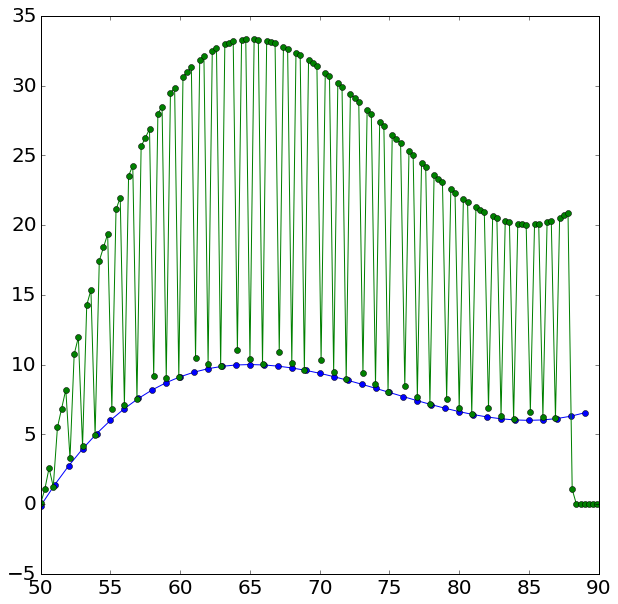

In [265]:
plt.figure(figsize=(10,10))
plt.plot(X,FX,'o-')
plt.plot(Y,aF,'o-')

In [261]:
def get_averaging_op( X, Y, dY, xbelow=0.0, xabove=0.0, mode='center' ):
    
    xa=X
    xb=X.copy()
    xb[0:-1]=xa[1:]
    xb[-1]=xb[-2] + xa[-2] - xa[-3]
    dX=xb-xa
        
    if mode == 'start':
        ya = Y
        yb = Y + dY
    elif mode == 'center':
        ya = Y - 0.5*dY
        yb = Y + 0.5*dY
    else:
        raise ValueError('Unknown mode= given')
    
        
    
    N = len(X)
    M = len(Y)
    A = np.zeros([M,N])
    
    m=0
    n=0

    while(m<M and n<N):
        
        #X:   a    b
        #     |    |
        #  | |
        #Y:a b 
        if xa[n] >= yb[m]:
            print(" 1: ",(m,n))
            m+=1
            continue
        #X: a    b
        #   |    |
        #         | |
        #Y:       a b 
        if ya[m] >= xb[n]:
            print(" 2: ",(m,n))
            n+=1
            continue 
        
        #case(3)
        #X: a      b
        #   | ---- |
        #     |  |
        #Y:   a  b
        if ya[m] > xa[n] and yb[m] < xb[n]:
            print(" 3: ",(m,n))
            SY = (ya[m] + yb[m] - 2*xa[n])/(2.0*dX[n])
            if n < (N-2):
                A[m,n] += (1.0 - SY) /dY[m]
                A[m,n+1] += SY /dY[m]
            m += 1
            continue
    
        #X:   a    b
        #     |----|
        #   |       |
        #Y: a       b 
        if ya[m] <= xa[n] and yb[m] >= xb[n]:
            print(" 4: ",(m,n))
            A[m,n] += 1.0/2.0
            if n < (N-2):
                A[m,n+1] += 1.0/2.0
                    
            n+=1            
            continue
            
        #X: a     b
        #   |  ---|
        #      |    |
        #Y:    a    b 
        if ya[m] <= xb[n] and yb[m] >= xb[n]:
            print(" 5: ",(m,n))
                
            xr = xb[n] - ya[m]
            u = (xb[n] + ya[m] - 2*xa[n])/(2*dX[n])
            if n < (N-2):
                A[m,n]   += (1 - u)*xr/dY[m]
                A[m,n+1]   += u*xr/dY[m] 
                
            n+=1
            continue

        #X:   a     b
        #      |--  |
        #   |    |
        #Y: a    b 
        if ya[m] <= xa[n] and yb[m] >= xa[n]:
            print(" 6: ",(m,n)) 

            xr = yb[m] - xa[n]
            
            if n < (N-2):
                A[m,n]  += xr*(1.0 - xr/(2*dX[n])) /dY[m]
                A[m,n+1]+= xr*xr/dY[m]

            m+=1
            continue
            
        
        print("none",(m,n))
    
    return A
    

In [171]:
xa[0], xb[0], ya[4], yb[4]

(60.0, 61.0, 60.975000000000001, 61.225000000000001)

In [187]:
m=4
n=1
xr = xb[n] - ya[m]
u = (xb[n] + ya[m] - 2*xa[n])/(2*dX[n])
xa[n], xb[n], ya[m], yb[m]

(61.0, 62.0, 60.975000000000001, 61.225000000000001)

In [175]:
(1 - u)*xr

0.0003125000000000533

In [169]:
xa=X
xb=X.copy()
xb[0:-1]=xa[1:]
xb[-1]=xb[-2] + xa[-2] - xa[-3]
dX=xb-xa

ya = Y - 0.5*dY
yb = Y + 0.5*dY



In [10]:
ya[m]

65.149999999999991

In [11]:
Y

array([ 64. ,  66.3,  68.6,  70.9,  73.2,  75.5,  77.8])

In [14]:
xa[n], xb[n]

(65.0, 66.0)

In [69]:
ya[5], yb[5]

(54.849999999999987, 58.149999999999984)